### System

The total Hamiltonian of the system is given by:

$
H = H_0 + H_{SB} = H_S + H_{B} + H_{SB}
$

where:
- \( H_S \) is the system Hamiltonian
- \( H_B \) is the bath Hamiltonian
- \( H_{SB} \) is the system-bath interaction Hamiltonian

#### System Hamiltonian

The system Hamiltonian \( H_S \) consists of the dimer Hamiltonian \( H_{dimer} \) and the interaction Hamiltonian \( H_{I}(t) \):

$
H_S = H_{dimer} + H_{I}(t)
$

The dimer Hamiltonian \( H_{dimer} \) is given by:

$
H_{dimer} = 0 |0\rangle\langle0| + \omega_a |A\rangle\langle A| + \omega_b |B\rangle\langle B| + J (|B\rangle\langle A| + |A\rangle\langle B|) + (\omega_a + \omega_b) |AB\rangle\langle AB|
$

where:
- \( |0\rangle \) is the ground state
- \( |A\rangle \) and \( |B\rangle \) are the excited states with energies \( \omega_a \) and \( \omega_b \) respectively
- \( J \) is the coupling constant between states \( |A\rangle \) and \( |B\rangle \)
- \( |AB\rangle \) is the doubly excited state with energy \( \omega_a + \omega_b \)

The bath Hamiltonian \( H_{B} \) is given by:

$
H_{B} = \sum_k \hbar \omega_k b_k^{\dagger} b_k
$

where:
- \( \hbar \omega_k \) is the energy of the \( k \)-th bath mode
- \( b_k^{\dagger} \) and \( b_k \) are the creation and annihilation operators for the \( k \)-th bath mode

The interaction Hamiltonian \( H_{I}(t) \) is given by:

$
H_{I}(t) = \hbar  g ( \Sigma_+ + \Sigma_-) \cdot (f(t) + f(t)^{*})
$

where:
- \( \Sigma_+ \) and \( \Sigma_- \) are the raising and lowering operators
- \( f(t) \) is the time-dependent field
- \( g =  \mu \cdot E_0 \) is the coupling constant with \( \mu \) being the dipole moment and \( E_0 \) the field amplitude

The electric field \( E(t) \) is defined as:

$
E(t) \equiv f(t) \cdot E_0 \propto \exp^{i \omega_a t + \phi} \cdot \delta(t)
$

### Decay Operators

The decay operators are defined as:

$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$

where:
- \( \gamma_0 \) is the decay rate
- \( \gamma_\phi \) is the dephasing rate
- \( \sigma_-^{(i)} \) and \( \sigma_z^{(i)} \) are the Pauli operators for the \( i \)-th state

In [15]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.constants as const
from qutip import *
import numpy as np
import itertools
import os

# Matplotlib settings according to LaTeX caption formatting
#mpl.rcdefaults() # resets all the settings to their default values
plt.rcParams.update({
    'text.usetex': True,              # Enable LaTeX for text rendering
    'font.family': 'serif',           # Use a serif font family
    'font.serif': 'Palatino',         # Set Palatino as the serif font
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.size': 20,                   # Font size for general text
    'axes.titlesize': 20,              # Font size for axis titles
    'axes.labelsize': 20,              # Font size for axis labels
    'xtick.labelsize': 20,             # Font size for x-axis tick labels
    'ytick.labelsize': 20,             # Font size for y-axis tick labels
    'legend.fontsize': 20,             # Font size for legends
    'figure.figsize': [8, 6],          # Size of the plot (width x height)
    'figure.autolayout': True,         # Automatic layout adjustment
    'savefig.format': 'svg',           # Default format for saving figures
    'figure.facecolor': 'none',        # Make the figure face color transparent
    'axes.facecolor': 'none',          # Make the axes face color transparent
    'savefig.transparent': True        # Save figures with transparent background
})

output_dir = os.path.join(os.getcwd(), 'output')  # Creates an 'output' directory in the current working directory
mpl.use('Agg')  # Use a non-interactive backend
os.makedirs(output_dir, exist_ok=True)
# Allows for interactive plots
# %matplotlib notebook
%matplotlib inline

# Phase Cycling for Averaging
phases = [np.pi / 2 for i in range(4)]  # GIVES WEIRD RESULTS

# Constants
Boltzmann = 1  # * const.Boltzmann
hbar      = 1  # * const.hbar
c         = 1  # * const.c
print(f"Reduced Planck's constant (hbar): {hbar} J·s,\nBoltzmann constant (k_B): {Boltzmann} J/K,\nSpeed of light (c): {c} m/s")

# System parameters
fac_twopi = 1 * 2 * np.pi
# Delta = 200  # Inhomogeneous distribution width of the monomer transitions (cm⁻¹, actually also s⁻1, when c = 1)

Reduced Planck's constant (hbar): 1 J·s,
Boltzmann constant (k_B): 1 J/K,
Speed of light (c): 1 m/s


In [60]:
# =============================
# SYSTEM PARAMETERS
# =============================
# Example usage
N_atoms = 2  # Set the number of atoms
Coupled = False  # Set coupling condition



# Define Atomic States
atom_g, atom_e = basis(2, 0), basis(2, 1)      # Ground, Excited states

omega_L = 1.005     # on resonance / in the middle of the two transitions 
E_freqs = [omega_L] * 3 # Laser frequencies

E0      = 1e-19 * 1.509 * 10**18
E_amps  = [E0, E0, 1e-2 * E0]

# Define variables common to both cases
gamma_0, gamma_phi = 1 / (300), 1 / (100)  # Decay and Dephasing rates with MESOLVE
pulse_duration = 15
Delta_ts = [pulse_duration / 2] * 3
fine_spacing = 2

# Initialize variables that are shared across cases but may be not used in one
omega_b, mu_b, rabi_0, rabi_gen, delta, theta, J, gamma_ab, Gamma_ab = None, None, None, None, None, None, None, None,None

if N_atoms == 1:
    psi_ini = atom_g
    omega_a = 1.005  # [fs⁻¹] = 16000 cm-1

    mu_a    = 1
    g_value = mu_a * E0
    rabi_0  = g_value / hbar

    H0 = hbar * omega_a * ket2dm(atom_e)
    eigenenergies, eigenstates = H0.eigenstates()

    delta    = omega_a - omega_L
    rabi_gen = np.sqrt(rabi_0**2 + delta**2)

    t_max_L = 6 * 2 * np.pi / omega_L
    t_prd   = 2 * np.pi / rabi_gen
    t_max_r = max(600, 5 * t_prd)
    t_max   = t_max_r

    SM_op   = mu_a * (atom_g * atom_e.dag()).unit()
    Dip_op  = SM_op + SM_op.dag()
    Deph_op = -atom_g * atom_g.dag() + atom_e * atom_e.dag()

    c_ops_list = [np.sqrt(gamma_0) * SM_op, np.sqrt(gamma_phi) * Deph_op]
    wc = 30*omega_a # Cutoff frequency for the bath spectral density
    g = .1           # Coupling strength to bath modes
    def ohmic_spectrum(w):
        return g * w/wc * np.exp(-w / wc) * ( w > 0.0) #  gamma_0 * (w > 0.0 )#
    a_ops_list = [[Dip_op, ohmic_spectrum],]

elif N_atoms == 2:
    psi_ini = tensor(atom_g, atom_g)

    pulse_duration = 5
    Delta_ts = [pulse_duration / 2] * 3
    fine_spacing = .1

    def Hamilton_dimer_sys(hbar, omega_a, omega_b, J):
        H = hbar * (omega_a * ket2dm(tensor(atom_e, atom_g))
                    + omega_b * ket2dm(tensor(atom_g, atom_e))
                    + J * (tensor(atom_e, atom_g) * tensor(atom_g, atom_e).dag() + tensor(atom_g, atom_e) * tensor(atom_e, atom_g).dag())
                    + (omega_a + omega_b) * ket2dm(tensor(atom_e, atom_e)))
        return H

    # If the excited states are coupled -> modify the energy levels
    if Coupled:
        def calc_mu(H, mu_a, mu_b, theta):
            eigenvecs = H.eigenstates()[1]
            mu_10 = -mu_a * np.sin(theta) + mu_b * np.cos(theta)
            sigma_m_10 = mu_10 * (eigenvecs[0] * eigenvecs[1].dag()).unit()
            if N_atoms == 1:
                return [(sigma_m_10 + sigma_m_10.dag())], [sigma_m_10]

            mu_20 =  mu_a * np.cos(theta) + mu_b * np.sin(theta)
            mu_31 = -mu_b * np.sin(theta) + mu_a * np.cos(theta)
            mu_32 =  mu_b * np.cos(theta) + mu_a * np.sin(theta)

            sigma_m_20 = mu_20 * (eigenvecs[0] * eigenvecs[2].dag()).unit()
            sigma_m_32 = mu_31 * (eigenvecs[1] * eigenvecs[3].dag()).unit()
            sigma_m_31 = mu_32 * (eigenvecs[2] * eigenvecs[3].dag()).unit()

            return [sigma_m_10, sigma_m_20, sigma_m_31, sigma_m_32]

        J = 0.01885  # fac_twopi * c * 300
        omega_a = 1.018  # fac_twopi * c * 16200
        omega_b = 0.9927  # fac_twopi * c * 15800
        mu_a = 1
        mu_b = -0.23

        theta = np.arctan(2 * J / (omega_a - omega_b)) / 2

        H0 = Hamilton_dimer_sys(hbar, omega_a, omega_b, J)
        eigenenergies, eigenstates = H0.eigenstates()
        sm_list = calc_mu(H0, mu_a, mu_b, theta) 

    else:
        J = 0.0
        omega_a = 1.028  # fac_twopi * c * 16360
        omega_b = 0.9827  # fac_twopi * c * 15640
        mu_a = 1
        mu_b = mu_a

        H0 = Hamilton_dimer_sys(hbar, omega_a, omega_b, J)
        eigenenergies, eigenstates = H0.eigenstates()
        sm_list = [tensor(atom_g * atom_e.dag(), qeye(2)), tensor(qeye(2), atom_g * atom_e.dag())]

    g_value = mu_a * E0
    t_prd = 2 * np.pi * hbar / (g_value)
    t_max_r = max(600, 5 * t_prd)
    t_max = t_max_r

    SM_op   = sum(sm_list)
    Dip_op  = SM_op + SM_op.dag()
    Deph_op =  tensor(-atom_g* atom_g.dag() + atom_e* atom_e.dag(), qeye(2)) + tensor(qeye(2), -atom_g* atom_g.dag() + atom_e* atom_e.dag())
    #Deph_op = -eigenstates[0] * eigenstates[0].dag() + sum([state * state.dag() for state in eigenstates[1:]]) # TODO now sure which one is correct

    # Coupling to the bath
    T = 1e-2 # Temperature
    g = 1
    wc = 30*omega_a
    def n(w):
        return 1 / (np.exp(w * (Boltzmann * T)**-1) - 1)
    def ohmic_spectrum(w):
        return g**2 * w / wc * np.exp(-w / wc) * (w > 0.0)
    """def Corr_fct(w):
            if w > 0:
                return n(w) * ohmic_spectrum(w)
            elif w < 0:
                return (1 + n(-w)) * ohmic_spectrum(-w)
            else:
                return g**2 / (wc * (Boltzmann * T)**-1)
        def gamma_ab(w):
            return np.sin(2 * theta)**2 * Corr_fct(w)
        Gamma_ab = 2 * np.cos(2 * theta)**2 * Corr_fct(0)
        decay_rates = [gamma_ab(wa - wb) for wa in eigenenergies for wb in eigenenergies] + [Gamma_ab] * 4
        #decay_rates = [rate for rate in decay_rates if rate != 0] # Remove zero rates
        #print(decay_rates)"""

    c_ops_list = [np.sqrt(gamma_0) * SM_op, np.sqrt(gamma_phi) * Deph_op]
    a_ops_list = [[Dip_op, ohmic_spectrum],]


else:
    raise ValueError("can only handle 1 or 2 atoms")

e_ops_list   = [ket2dm(v) for v in H0.eigenstates()[1]]
e_ops_labels = [f"state{i}" for i in range(len(H0.eigenstates()[1]))]

In [61]:
# Test
"""def calc_mu(H, mu_a, mu_b, theta):
    eigenvecs = H.eigenstates()[1]
    mu_10 = -mu_a * np.sin(theta) + mu_b * np.cos(theta)
    sigma_m_10 = mu_10 * (eigenvecs[0] * eigenvecs[1].dag()).unit()
    if N_atoms == 1:
        return [(sigma_m_10 + sigma_m_10.dag())], [sigma_m_10]

    mu_20 =  mu_a * np.cos(theta) + mu_b * np.sin(theta)
    mu_31 = -mu_b * np.sin(theta) + mu_a * np.cos(theta)
    mu_32 =  mu_b * np.cos(theta) + mu_a * np.sin(theta)

    sigma_m_20 = mu_20 * (eigenvecs[0] * eigenvecs[2].dag()).unit()
    sigma_m_32 = mu_31 * (eigenvecs[1] * eigenvecs[3].dag()).unit()
    sigma_m_31 = mu_32 * (eigenvecs[2] * eigenvecs[3].dag()).unit()

    return [sigma_m_10, sigma_m_20, sigma_m_31, sigma_m_32]

J = 0.0
omega_a = 1.028  # fac_twopi * c * 16360
omega_b = 0.9827  # fac_twopi * c * 15640
mu_a = 1
mu_b = mu_a
theta = np.arctan(2 * J / (omega_a - omega_b)) / 2

H0 = Hamilton_dimer_sys(hbar, omega_a, omega_b, J)
#print(H0)
eigenenergies, eigenstates = H0.eigenstates()
sm_list = calc_mu(H0, mu_a, mu_b, theta) 
SM_op   = sum(sm_list)
Dip_op  = SM_op + SM_op.dag()
Deph_op = -eigenstates[0] * eigenstates[0].dag() + sum([state * state.dag() for state in eigenstates[1:]])
print(SM_op, Dip_op, Deph_op)

sm_list = [tensor(atom_g * atom_e.dag(), qeye(2)), tensor(qeye(2), atom_g * atom_e.dag())]
SM_op   = sum(sm_list)
Dip_op  = SM_op + SM_op.dag()
Deph_op =  tensor(-atom_g* atom_g.dag() + atom_e* atom_e.dag(), qeye(2)) + tensor(qeye(2), -atom_g* atom_g.dag() + atom_e* atom_e.dag())
print(SM_op, Dip_op, Deph_op)"""

'def calc_mu(H, mu_a, mu_b, theta):\n    eigenvecs = H.eigenstates()[1]\n    mu_10 = -mu_a * np.sin(theta) + mu_b * np.cos(theta)\n    sigma_m_10 = mu_10 * (eigenvecs[0] * eigenvecs[1].dag()).unit()\n    if N_atoms == 1:\n        return [(sigma_m_10 + sigma_m_10.dag())], [sigma_m_10]\n\n    mu_20 =  mu_a * np.cos(theta) + mu_b * np.sin(theta)\n    mu_31 = -mu_b * np.sin(theta) + mu_a * np.cos(theta)\n    mu_32 =  mu_b * np.cos(theta) + mu_a * np.sin(theta)\n\n    sigma_m_20 = mu_20 * (eigenvecs[0] * eigenvecs[2].dag()).unit()\n    sigma_m_32 = mu_31 * (eigenvecs[1] * eigenvecs[3].dag()).unit()\n    sigma_m_31 = mu_32 * (eigenvecs[2] * eigenvecs[3].dag()).unit()\n\n    return [sigma_m_10, sigma_m_20, sigma_m_31, sigma_m_32]\n\nJ = 0.0\nomega_a = 1.028  # fac_twopi * c * 16360\nomega_b = 0.9827  # fac_twopi * c * 15640\nmu_a = 1\nmu_b = mu_a\ntheta = np.arctan(2 * J / (omega_a - omega_b)) / 2\n\nH0 = Hamilton_dimer_sys(hbar, omega_a, omega_b, J)\n#print(H0)\neigenenergies, eigenstates = 

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.20s / Remaining 00:00:00:06

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


 Total run time:   6.25s*] Elapsed 6.25s / Remaining 00:00:00:00[*********77%******     ] Elapsed 4.83s / Remaining 00:00:00:01
 Total run time:   7.49s*] Elapsed 7.49s / Remaining 00:00:00:00[*********72%*****      ] Elapsed 5.46s / Remaining 00:00:00:02


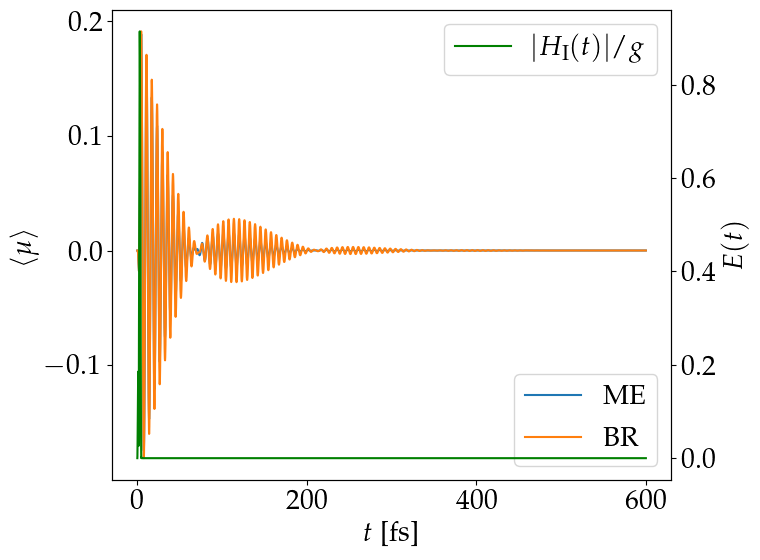

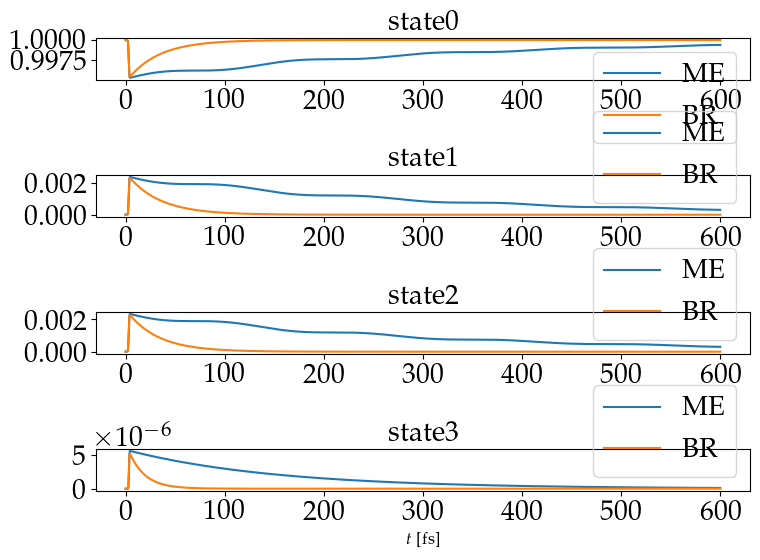

In [62]:
# =============================
# MORE FUNCTIONS
# =============================
def plot_positive_color_map(datas, T=np.inf, space="real", type="real", positive=False, safe=False): # ALSO add every varialbe that is used and make it work with N_atoms = 2
    """
    Create a color plot of 2D functional data for positive x and y values only.

    Parameters:
        datas (tuple): Tuple containing (x, y, data) where x and y are 1D arrays and data is a 2D array.
        T (float): Temperature parameter to include in plot title and file name.
        space (str): Either 'real' or 'freq' specifying the space of the data.
        type (str): Type of data ('real', 'imag', 'abs', or 'phase'). Used only if space="freq".
        positive (bool): Whether to use only positive values of x and y.
        safe (bool): If True, saves the plot to a file.
        mu_a (float): Scaling factor for the data.
        N_atoms (int): Number of atoms, used in the filename.
        E0 (float): Scaling factor for energy, used in the filename.
        omega_a (float): Scaling factor for frequency, used in the filename.
        omega_L (float): Scaling factor for laser frequency, used in the filename.
        g_value (float): Scaling factor for coupling strength, used in the filename.
        rabi_0 (float): Rabi frequency, used in the filename.
        delta (float): Detuning, used in the filename.
        rabi_gen (float): Generated Rabi frequency, used in the filename.
        gamma_0 (float): Ground-state decay rate, used in the filename.
        gamma_phi (float): Phase decay rate, used in the filename.
        J (float, optional): Coupling constant (only if N_atoms == 2).
        output_dir (str, optional): Directory to save the plot.

    Returns:
        None
    """
    # Ensure datas is a tuple with (x, y, data)
    if not isinstance(datas, tuple) or len(datas) != 3:
        raise ValueError("datas must be a tuple of (x, y, data)")

    x, y, data = datas

    # Validate that x, y, and data are numpy arrays
    x = np.array(x)
    y = np.array(y)
    data = np.array(data)

    # Check if data dimensions match x and y
    if data.shape[1] != len(x):
        raise ValueError(f"Length of x ({len(x)}) must match the number of columns in data ({data.shape[1]}).")
    if data.shape[0] != len(y):
        raise ValueError(f"Length of y ({len(y)}) must match the number of rows in data ({data.shape[0]}).")

    # Filter for positive x and y values if requested
    if positive:
        positive_x_indices = np.where(x > 0)[0]
        positive_y_indices = np.where(y > 0)[0]
        x = x[positive_x_indices]
        y = y[positive_y_indices]
        data = data[np.ix_(positive_y_indices, positive_x_indices)]

    # Set the label and title based on the space
    label = r"$\propto E_{\text{out}} / E_0$"
    if space == "real":
        colormap = "viridis"
        title = f"Real space 2D Spectrum"
        if T != np.inf:
            title += f" at T ={T:.2f}"
        x_title = r"$t_{\text{det}}$ [fs]"
        y_title = r"$\tau_{\text{coh}}$ [fs]"

    elif space == "freq":
        x = x * 10 / 3
        y = y * 10 / 3
        colormap = "plasma"
        if type == "real":
            title = f"Freq space, Real 2D Spectrum"
            data = np.real(data)
        elif type == "imag":
            title = f"Freq space, Imag 2D Spectrum"
            data = np.imag(data)
        elif type == "abs":
            title = f"Freq space, Abs 2D Spectrum"
            data = np.abs(data)
        elif type == "phase":
            title = "Freq space, Phase 2D Spectrum"
            data = np.angle(data)
        else:
            raise ValueError("Invalid Type. Must be 'real', 'imag', 'abs', or 'phase'.")
        
        if T != np.inf:
            title += f" at T ={T:.2f}"

        x_title = r"$\omega_{t_{det}}$ [$10^4$ cm$^{-1}$]"
        y_title = r"$\omega_{\tau_{coh}}$ [$10^4$ cm$^{-1}$]"
    else:
        raise ValueError("Invalid space. Must be 'real' or 'freq'.")

    # Add extra values for x and y to ensure correct pcolormesh behavior
    x = np.concatenate([x, [x[-1] + (x[-1] - x[-2])]])  
    y = np.concatenate([y, [y[-1] + (y[-1] - y[-2])]])

    # Plot the color map
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(x, y, data / mu_a, shading="auto", cmap=colormap)
    plt.colorbar(label=label)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # Save the plot if safe is True and output_dir is provided
    if safe and output_dir is not None:
        assert os.path.isdir(output_dir), f"Output directory {output_dir} does not exist."

        filename_parts = [
            f"N={N_atoms}",
            f"mua={mu_a:.0f}",
            f"E0={E0:.2e}",
            f"wa={omega_a:.2f}",
            f"wL={omega_L / omega_a:.1f}wa",
            f"g={g_value:.2e}",
            f"rabi0={rabi_0:.2f}",
            f"delta={delta:.2f}",
            f"rabigen={rabi_gen:.2f}",
            f"g0={gamma_0:.3f}",
            f"gphi={gamma_phi:.3f}",
            f"pos={positive}",
            f"space={space}"
        ]

        if N_atoms == 2 and J is not None:
            filename_parts.insert(1, f"J_{J:.1f}")

        if space == "freq":
            filename_parts.append(f"type_{type}")

        file_name_combined = "_".join(filename_parts) + ".svg"
        save_path_combined = os.path.join(output_dir, file_name_combined)
        plt.savefig(save_path_combined)
    else:
        print("Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.")

    plt.show()


    plt.show()
def Plot_example_evo(T_val, tau, phi_1, phi_2, times_0, times_1, times_2, data_1, data_2, data_f, i, j, k):
    args0 = get_pulse_args(times_0[0], 0, phi_1)
    args1 = get_pulse_args(times_0[i], 1, phi_2)
    args2 = get_pulse_args(times_1[j-i], 2, 0)

    times1 = times_0[:i]
    times2 = times_1[:j]
    times3 = times_2

    # Calculate the electric fields for each time range
    E_1 = [E_amps[0] * (El_field_pulse(t, args0)) for t in times1]
    E_2 = [E_amps[1] * (El_field_pulse(t, args1)) for t in times2]
    E_3 = [E_amps[2] * (El_field_pulse(t, args2)) for t in times3]
    times_plot = np.concatenate([times1, times2, times3])
    E_total = E_1 + E_2 + E_3

    fig, axs = plt.subplots(len(e_ops_list)+1, 1, figsize=(15, 10), sharex=True)

    axs[0].plot(times_plot, E_total, label='Electric Field (Real part)', color='black')
    axs[0].set_ylabel('E')

    # Add vertical lines to mark pulse times
    axs[0].axvline(times_0[0] + Delta_ts[0], color='r', linestyle='--', label='Pulse 1')
    axs[0].axvline(times_0[i] + Delta_ts[1], color='g', linestyle='--', label='Pulse 2')
    axs[0].axvline(times_1[j-i] + Delta_ts[2], color='g', linestyle='--', label='Pulse 3')
    axs[0].axvline(times_2[k], color='b', linestyle='--', label='Detection')
    axs[0].legend()

    # Initialize an empty list to store all the data for plotting
    datas = []

    # Append the data for each quantum state based on the times
    for idx in range(len(e_ops_list)):
        datas.append(np.concatenate([data_1.expect[idx][:i], data_2.expect[idx][:j], data_f.expect[idx]]))  # data for first state

    # Loop over the datas and plot each expectation value
    for idx, (data, label) in enumerate(zip(datas, e_ops_labels)):
        axs[idx+1].plot(times_plot, data)
        axs[idx+1].set_ylabel(label)
        axs[idx+1].legend()

    fig.suptitle(f"tau = {tau:.2f}, T = {T_val:.2f}")
    axs[-1].set_xlabel('t [fs]')
    plt.show()
def Plot_example_evo_with_DipOp(T_val, tau, phi_1, phi_2, times_0, times_1, times_2, data_1, data_2, data_f, i, j, k):
    args0 = get_pulse_args(times_0[0], 0, phi_1)
    args1 = get_pulse_args(times_0[i], 1, phi_2)
    args2 = get_pulse_args(times_1[j-i], 2, 0)

    times1 = times_0[:i]
    times2 = times_1[:j]
    times3 = times_2

    # Calculate the electric fields for each time range
    E_1 = [E_amps[0] * (El_field_pulse(t, args0)) for t in times1]
    E_2 = [E_amps[1] * (El_field_pulse(t, args1)) for t in times2]
    E_3 = [E_amps[2] * (El_field_pulse(t, args2)) for t in times3]
    times_plot = np.concatenate([times1, times2, times3])
    E_total = E_1 + E_2 + E_3

    fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

    # Plot the electric field
    axs[0].plot(times_plot, E_total, label='Electric Field (Real part)', color='black')
    axs[0].set_ylabel('E')

    # Add vertical lines to mark pulse times
    axs[0].axvline(times_0[0] + Delta_ts[0], color='r', linestyle='--', label='Pulse 1')
    axs[0].axvline(times_0[i] + Delta_ts[1], color='g', linestyle='--', label='Pulse 2')
    axs[0].axvline(times_1[j-i] + Delta_ts[2], color='g', linestyle='--', label='Pulse 3')
    axs[0].axvline(times_2[k], color='b', linestyle='--', label='Detection')
    axs[0].legend()

    # Initialize an empty list to store all the expectation values of Dip_op
    datas = []
    expect_1 = [expect(Dip_op, state) for state in data_1.states]
    expect_2 = [expect(Dip_op, state) for state in data_2.states]
    expect_f = [expect(Dip_op, state) for state in data_f.states]
    # Append the expectation value of Dip_op for each state at the corresponding times
    for data in [data_1, data_2, data_f]:
        # Calculate expect(Dip_op, psi) at the appropriate indices
        datas.append(np.concatenate([expect_1[:i], expect_2[:j], expect_f]))

    # Plot the expectation values for each state
    for data in datas:
        axs[1].plot(times_plot, data)

    axs[1].set_ylabel('Expectation of Dip_op')
    axs[1].legend()

    fig.suptitle(f"tau = {tau:.2f}, T = {T_val:.2f}")
    axs[-1].set_xlabel('t [fs]')
    plt.show()
def get_t_tau_times_for_T(T_val, spacing):
    # Adjust the first and last entries of times_tau
    first_tau = (Delta_ts[0] + Delta_ts[1])
    last_tau = np.floor((t_max - Delta_ts[2] - T_val - Delta_ts[0]) / spacing) * spacing
    times_tau = np.arange(first_tau, last_tau, spacing)
    # Adjust the first and last entries of times_t
    first_t = (Delta_ts[2])
    last_t = np.floor((t_max - Delta_ts[0] - T_val - 2 * Delta_ts[2]) / spacing) * spacing
    times_t = np.arange(first_t, last_t, spacing)

    return times_tau, times_t
def pulse_envelope(t, t0, Delta):
    E = np.cos(np.pi * (t - t0) / (2 * Delta))**2 * np.heaviside(t - (t0 - Delta), 0) * np.heaviside(t0 + Delta - t, 0)
    return 1*E
def El_field_pulse(t, args):
    """ Define a time-dependent electric field pulse. """
    t0, Delta, omega, phi, E0 = args['time'], args['Delta'], args['omega'], args['phi'], args['E_amp']
    E = pulse_envelope(t, t0, Delta)
    return  E * np.exp(1j * (omega * t) + phi) #    phase kick
def El_field_op_pulse(t, args):
    E = El_field_pulse(t, args)
    E_op = E + np.conj(E)
    return E_op
def get_pulse_args(t, i, phi):
    return {
        'phi': phi,
        'time': t + Delta_ts[i],
        'omega': E_freqs[i],
        'Delta': Delta_ts[i],
        'E_amp': E_amps[i]
    }

def process_one_combination(phi_1, phi_2, times_T):
    # Function to handle parallel processing for each phi1, phi2 combination
    full_data_array = np.empty((len(times_T)), dtype=object)
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(compute_two_dimensional_polarization, times_T[i], phi_1, phi_2) for i in range(len(times_T))]
        for i, future in enumerate(as_completed(futures)):
            full_data_array[i] = future.result()
    return full_data_array
def parallel_process_all_combinations(phases, times_T):
    # Call the function to parallelize the whole process
    all_results = {}
    with ProcessPoolExecutor() as executor:
        futures = [(executor.submit(process_one_combination, phi1, phi2, times_T), phi1, phi2) for phi1, phi2 in itertools.product(phases, phases)]
        for future, phi1, phi2 in futures:
            all_results[(phi1, phi2)] = future.result()
    return all_results
def average_the_results(results, times_T):
    # the time data can even be padded
    num_combinations = len(results)
    num_time_steps = len(times_T) - 1
    averaged_data_array = np.empty(num_time_steps, dtype=object)
    for i in range(num_time_steps):
        sum_data = None
        ts, taus = None, None
        for _, full_data_array in results.items():
            ts, taus, data_time = full_data_array[i]
            if sum_data is None:
                sum_data = np.zeros_like(data_time)
            sum_data += data_time
        averaged_data = sum_data / num_combinations
        pad_val = 1
        padded_size = (int(np.round(averaged_data.shape[0] * pad_val)), int(np.round(averaged_data.shape[1] * pad_val)))
        padded_averaged_data = np.pad(averaged_data, ((0, padded_size[0] - averaged_data.shape[0]), (0, padded_size[1] - averaged_data.shape[1])), mode='constant', constant_values=0)
        padded_ts = np.linspace(ts[0], np.round(ts[-1] * pad_val), padded_size[1])
        padded_taus = np.linspace(taus[0], np.round(taus[-1] * pad_val), padded_size[0])
        averaged_data_array[i] = (padded_ts, padded_taus, padded_averaged_data)
    return averaged_data_array
def get_all_results(phases, times_T):
    all_results = parallel_process_all_combinations(phases, times_T)
    sorted_results = {k: sorted(v, key=lambda data_item: len(data_item[0]), reverse=True)[:-1] for k, v in all_results.items()}
    averaged_results = average_the_results(sorted_results, times_T)
    return averaged_results
def extend_and_plot_results(averaged_results):
    global_ts        = averaged_results[0][0]
    global_taus      = averaged_results[0][1]
    global_t_freqs   = np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0]))
    global_tau_freqs = np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0]))
    global_data_time = np.zeros((len(global_taus), len(global_ts)))
    global_data_freq = np.zeros((len(global_taus), len(global_ts)), dtype=np.complex64)

    def find_closest_index(local_times, global_times):
        return [np.argmin(np.abs(global_times - local_time)) for local_time in local_times]

    for i, datas in enumerate(averaged_results):
        (ts, taus, data_time)
        data_extended_time = np.zeros_like(global_data_time)
        tau_indices = find_closest_index(datas[1], global_taus)
        t_indices = find_closest_index(datas[0], global_ts)
        for local_tau_idx, global_tau_idx in enumerate(tau_indices):
            for local_t_idx, global_t_idx in enumerate(t_indices):
                data_extended_time[global_tau_idx, global_t_idx] = datas[2][local_tau_idx, local_t_idx]
        data_extended_freq = np.fft.fft2(data_extended_time)
        global_data_time += data_extended_time
        global_data_freq += data_extended_freq
        plot_positive_color_map(datas, times_T[i])
        plot_positive_color_map((global_t_freqs, global_tau_freqs, data_extended_freq), times_T[i], space="freq", positive=True, type="abs")

    global_data_time /= len(averaged_results)
    global_data_freq /= len(averaged_results)
    plot_positive_color_map((global_ts, global_taus, global_data_time), safe=False)
    plot_positive_color_map((global_t_freqs, global_tau_freqs, global_data_freq), space="freq", type="abs", positive=True, safe=False)
    return global_data_time, global_data_freq

def H_int(t, args):
    E0 = args['E_amp']
    g = E0 * mu_a / 2
    return g * Dip_op.unit() * (El_field_op_pulse(t, args))
def H_sys(args):
    return H0 + QobjEvo(H_int, args)

def get_all_results(phases, times_T):
    all_results = parallel_process_all_combinations(phases, times_T)
    sorted_results = {k: sorted(v, key=lambda data_item: len(data_item[0]), reverse=True)[:-1] for k, v in all_results.items()}
    averaged_results = average_the_results(sorted_results, times_T)
    return averaged_results

def test(test_args, times, e_ops_list, e_ops_labels, g_value):
    progress_bar = 'enhanced'
    options = Options(
        store_states=True,
        progress_bar=progress_bar)

    result_me = mesolve(H_sys(test_args), psi_ini, times, c_ops=c_ops_list, e_ops=e_ops_list, args=test_args, options=options)
    result_br = brmesolve(H_sys(test_args), psi_ini, times, a_ops=a_ops_list, e_ops=e_ops_list, args=test_args, options=options)

    fig, ax1 = plt.subplots()
    ax1.plot(times, expect(Dip_op, result_me.states), label=r"\text{ME}")
    ax1.plot(times, expect(Dip_op, result_br.states), label=r"\text{BR}")
    ax1.set_xlabel(r"$t$ [fs]")
    ax1.set_ylabel(r"$\langle \mu \rangle$")
    ax2 = ax1.twinx()
    ax2.plot(times, [H_int(t, test_args).norm() / g_value for t in times], label=r"$|H_\text{I}(t)|/g$", color='green')
    ax2.set_ylabel(r"$E(t)$")
    ax1.legend(loc="lower right")
    ax2.legend(loc="upper right")

    fig, axes = plot_expectation_values([result_me, result_br])
    for ax, label in zip(axes, e_ops_labels):
        ax.legend(labels=[r"\text{ME}", r"\text{BR}"])
        ax.set_title(label)
    plt.xlabel(r"$t$ [fs]")
    plt.show()


# Print the values
test_args = get_pulse_args(0,0,0)
times     = np.arange(0, t_max, fine_spacing)       # High-resolution times array to do the evolutions
#################
# TEST
##################
#plt.plot(times, [np.real(El_field_op_pulse(t, test_args)) for t in times]);plt.show();
test(test_args, times, e_ops_list, e_ops_labels, g_value)

In [ ]:
first_entry = (Delta_ts[1] + Delta_ts[2])
#sparse_spacing  = 10 * fine_spacing         # for waiting times T
#last_entry = np.floor((t_max - (2 * Delta_ts[0] + Delta_ts[1] + Delta_ts[2])) / sparse_spacing) * sparse_spacing
#times_T = np.arange(first_entry, last_entry, sparse_spacing)
times_T =  np.array([0,16,30,46,62,108,140, 310]) + first_entry # np.arange(first_entry, last_entry, sparse_spacing)

## Calculations
def compute_pulse(psi_ini, times, phi, i):
    ### Compute Pulse
    progress_bar = ""
    if i == 2 and times[0] >= times[len(times)//2]:
        progress_bar='enhanced'    
    options = Options(store_states=True, progress_bar=progress_bar,)
    args = get_pulse_args(times[0], i, phi)
    result = brmesolve(H_sys(args), psi_ini, times, e_ops=e_ops_list, a_ops=a_ops_list, options=options)
    #result = mesolve(H_sys(args), psi_ini, times, e_ops=e_ops_list, c_ops=c_ops_list, options=options)
    return result
def compute_two_dimensional_polarization(T_val, phi_1, phi_2):
    ### Compute Two-Dimensional Polarization
    # get the symmetric times, t / tau
    tau_values, t_values = get_t_tau_times_for_T(T_val, fine_spacing)

    # initialize the time domain Spectroscopy
    data = np.zeros((len(tau_values), len(t_values)))

    # only make the necessary steps (don't calculate too many states that we don't need)
    index_0 = np.abs(times - (tau_values[-1] - Delta_ts[1] + Delta_ts[0])).argmin()  # Find the closest index to reduce computation time
    # select range  ->  to reduce computation time
    times_0 = times[:index_0+1]

    # calculate the evolution of the first pulse in the desired range for tau
    data_1  = compute_pulse(psi_ini, times_0, phi_1, 0)

    # for every tau value -> calculate the next pulses
    for tau_idx, tau in enumerate(tau_values):
        # find the position in times, which corresponds to the current tau
        i       = np.abs((times_0 + Delta_ts[1] - Delta_ts[0]) - tau_values[tau_idx]).argmin()

        # take this state and evolve it with the second pulse, but only as far as desired
        psi_1   = data_1.states[i]

        # select range  ->  to reduce computation time
        j = np.abs((times - times_0[i] - Delta_ts[1] + Delta_ts[2]) - T_val).argmin()
        times_1 = times[i:j+1]

        # compute second pulse for waiting time T
        data_2  = compute_pulse(psi_1, times_1, phi_2, 1)
        psi_2   = data_2.states[j-i]

        # compute the last pulse with times t
        times_2 = times[j:]
        data_f  = compute_pulse(psi_2, times_2, 0, 2)

        for t_idx, t in enumerate(t_values):
            # store the data for the case
            if t_idx + tau_idx < len(tau_values):

                k = np.abs(t_values[t_idx] - (times_2 - times_2[0] - Delta_ts[2])).argmin()
                psi_f = data_f.states[k]
                data[tau_idx, t_idx] = expect(Dip_op, psi_f)

                # make one plot for this case
                #if t == t_values[len(t_values)//2] and tau == tau_values[len(tau_values)//3]:
                #    Plot_example_evo_with_DipOp(T_val, tau, phi_1, phi_2, times_0, times_1, times_2, data_1, data_2, data_f, i, j, k)
                #    Plot_example_evo(T_val, tau, phi_1, phi_2, times_0, times_1, times_2, data_1, data_2, data_f, i, j, k)
    return tau_values, t_values, data

### Test Computation
T_test = times_T[0]
data_test_0 = compute_two_dimensional_polarization(T_test, phases[0], phases[0])

Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.


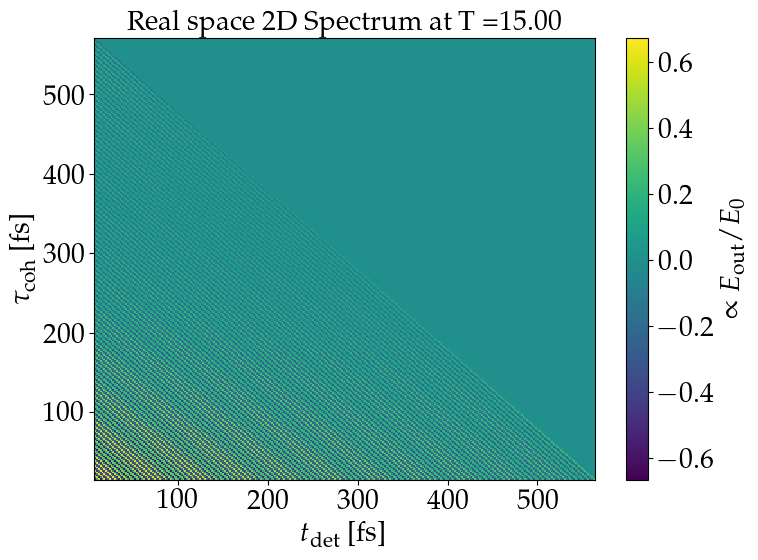

Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.


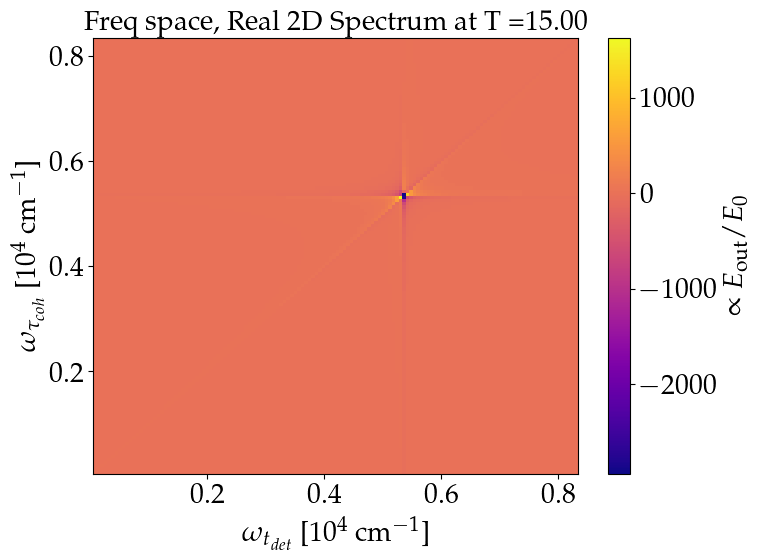

In [ ]:
safe=False
plot_positive_color_map((data_test_0[1], data_test_0[0], data_test_0[2]), T=T_test, safe=safe)
tfreqs = np.fft.fftfreq(len(data_test_0[1]), d=(data_test_0[1][1] - data_test_0[1][0]))
taufreqs = np.fft.fftfreq(len(data_test_0[0]), d=(data_test_0[0][1] - data_test_0[0][0]))
plot_positive_color_map((tfreqs, taufreqs, np.fft.fft2(data_test_0[2])), positive=True, type="real", space="freq", T=T_test, safe=safe)

In [ ]:
# RESULTS from 2D Spectroscopy with all phases and times_T, already averaged over all phi
RESULT = get_all_results(phases, times_T)

In [ ]:
# Example usage
global_time_result, global_freq_result = extend_and_plot_results(RESULT)

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/brmesolve.py:169: FutureWarning: c_ops, e_ops, args and options will be keyword only from qutip 5.3
  warnings.warn(


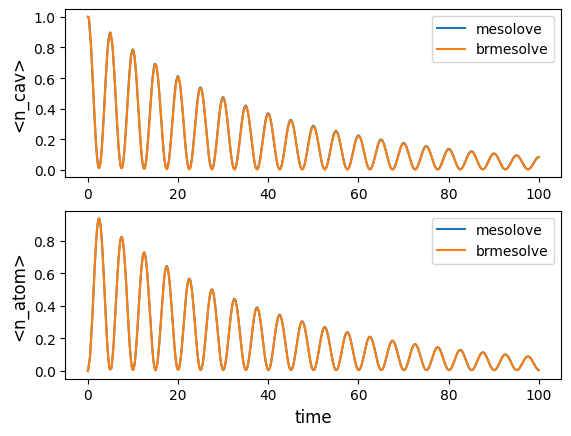

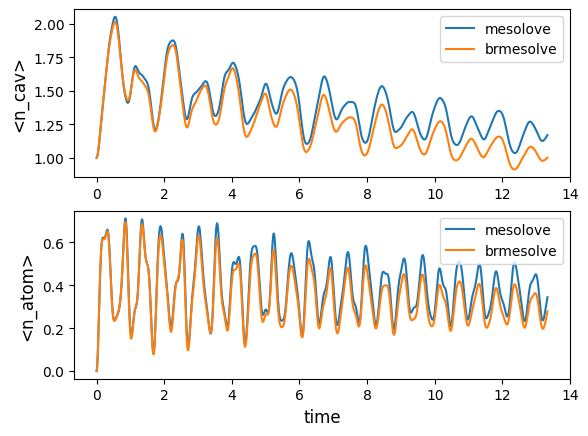

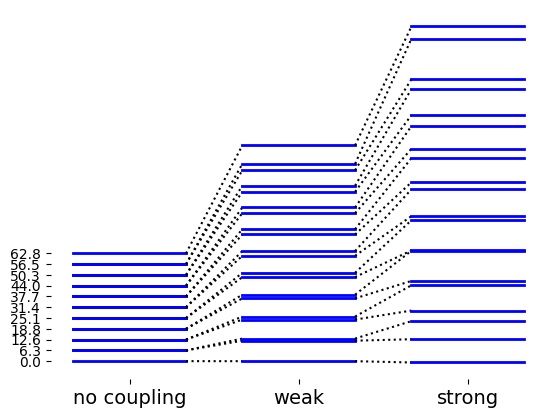

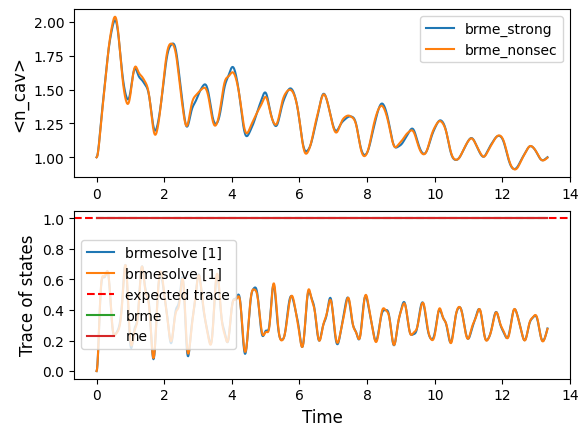

In [4]:
N = 10  # num. cavity modes

# operators
a = tensor(destroy(N), identity(2))
sm = tensor(identity(N), destroy(2))

# expectation operators
e_ops = [a.dag() * a, sm.dag() * sm]

# initial state
psi0 = ket2dm(tensor(basis(N, 1), basis(2, 0)))

w0 = 1.0 * 2 * np.pi
g_weak = 0.1 * 2 * np.pi
g_strong = 0.75 * 2 * np.pi
kappa = 0.05

# collapse operators (for mesolve)
c_ops = [np.sqrt(kappa) * a]
# noise power spectrum (for brmesolve)
a_ops = [[(a + a.dag()), lambda w: kappa * (w > 0)]]

# Hamiltonians
H_no = w0 * a.dag() * a + w0 * sm.dag() * sm
H_weak = w0 * a.dag() * a + w0 * sm.dag() * sm + \
         g_weak * (a + a.dag()) * (sm + sm.dag())
H_strong = w0 * a.dag() * a + w0 * sm.dag() * sm + \
           g_strong * (a + a.dag()) * (sm + sm.dag())


# times for simulation
times = np.linspace(0, 10 * 2 * np.pi / g_weak, 1000)
# simulation
result_me_weak = mesolve(H_weak, psi0, times, c_ops, e_ops)
result_brme_weak = brmesolve(H_weak, psi0, times, a_ops, e_ops)
fig, axes = plot_expectation_values(
    [result_me_weak, result_brme_weak], ylabels=["<n_cav>", "<n_atom>"]
)
for ax in axes:
    ax.legend(['mesolove', 'brmesolve'], loc='upper right')
    
    
# times for simulation
times = np.linspace(0, 10 * 2 * np.pi / g_strong, 1000)
# simulation
result_me_strong = mesolve(H_strong, psi0, times, c_ops, e_ops)
result_brme_strong = brmesolve(H_strong, psi0, times, a_ops, e_ops)
fig, axes = plot_expectation_values(
    [result_me_strong, result_brme_strong], ylabels=["<n_cav>", "<n_atom>"]
)
for ax in axes:
    ax.legend(['mesolove', 'brmesolve'], loc='upper right')

plot_energy_levels([H_no, H_weak, H_strong],
                   h_labels=["no coupling", "weak", "strong"]);





result_brme_nonsec = brmesolve(H_strong, psi0, times, a_ops,
                               sec_cutoff=-1, e_ops=e_ops)
fig, axes = plot_expectation_values(
    [result_brme_strong, result_brme_nonsec], ylabels=["<n_cav>", "<n_atom>"]
)
for ax in axes:
    ax.legend(['brme_strong', 'brme_nonsec'], loc='upper right')



# calculate states for weak coupling
me_states = mesolve(H_weak, psi0, times, c_ops, e_ops=[])
brme_states = brmesolve(H_weak, psi0, times, a_ops, e_ops=[])
# plot the traces and expected trace
plt.axhline(1.0, label="expected trace", c="red", linestyle="--")
plt.plot(times, [state.tr() for state in brme_states.states], label="brme")
plt.plot(times, [state.tr() for state in me_states.states], label="me")
plt.legend(), plt.xlabel("Time"), plt.ylabel("Trace of states");